In [1]:
import osmnx as ox
import shapely.geometry as geom
import networkx as  nx
from shapely.geometry import box
import os

In [2]:
redo = True
graph_path = "porto.graphml"

In [ ]:
patch_size = 0.01
img_size = (224,224)

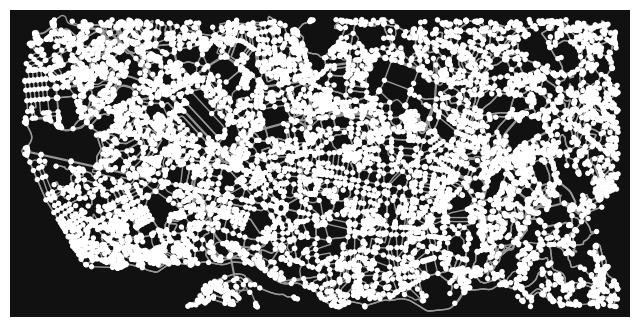

In [11]:
import matplotlib.pyplot as plt

# Define bounding box (lon_min, lat_min, lon_max, lat_max)
bbox = (-8.6886988, 41.1406333, -8.5559061 + patch_size, 41.1858412 + patch_size)

# Download the driving network within this box
porto_graph = ox.graph_from_bbox(bbox=bbox, network_type='drive')

# Plot the graph
fig, ax = ox.plot_graph(porto_graph)

In [12]:
import contextily as ctx
import geopandas as gpd
import math
from PIL import Image, ImageDraw
import json

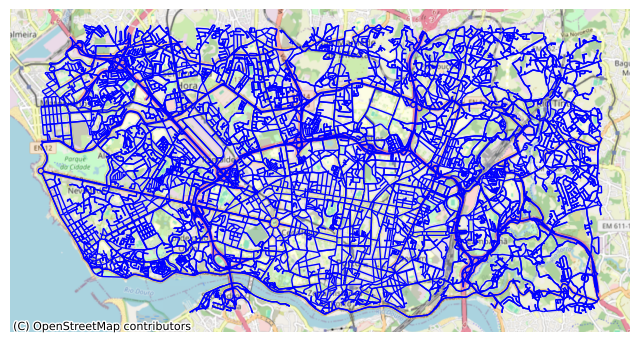

In [20]:
nodes, edges = ox.graph_to_gdfs(porto_graph)

# Plot OSM basemap
fig, ax = plt.subplots(figsize=(8, 8))
edges.plot(ax=ax, linewidth=1, color="blue")
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs=edges.crs)
plt.axis("off")
plt.savefig("osm_tile_map.png", bbox_inches="tight", dpi=300)

In [41]:
plt.savefig("porto_patch.svg", format='svg', bbox_inches='tight', pad_inches=0, transparent=True)
plt.close(fig)

<Figure size 640x480 with 0 Axes>

In [13]:
import json
def save_patches_with_basemap(graph, patch_size=0.01, prefix="porto_patch",
                              out_dir="data/patches", img_size=(256, 256)):
    os.makedirs(out_dir, exist_ok=True)

    # Get graph bounds (fixed to Porto region for consistency)
    nodes, edges = ox.graph_to_gdfs(graph)
    minx, miny, maxx, maxy = -8.6886988, 41.1406333, -8.5559061 + patch_size, 41.1858412 + patch_size

    patch_id = 0
    metadata = []

    x = minx
    while x < maxx:
        y = miny
        while y < maxy:
            bbox = box(x, y, x + patch_size, y + patch_size)
            sub_nodes = nodes[nodes.within(bbox)]
            sub_edges = edges[edges.intersects(bbox)]

            if len(sub_nodes) > 0 and len(sub_edges) > 0:
                # Create GeoDataFrames in Web Mercator (EPSG:3857)
                sub_nodes_proj = sub_nodes.to_crs(epsg=3857)
                sub_edges_proj = sub_edges.to_crs(epsg=3857)
                bbox_proj = gpd.GeoSeries([bbox], crs="EPSG:4326").to_crs(epsg=3857).iloc[0]

                # Plot OSM basemap + edges
                fig, ax = plt.subplots(figsize=(4, 4))
                sub_edges_proj.plot(ax=ax, linewidth=1.2, color="black", alpha=0.8)
                sub_nodes_proj.plot(ax=ax, markersize=3, color="red", alpha=0.6)

                # Add basemap from contextily (Stamen / OpenStreetMap)
                ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=15)

                # Limit to patch bounding box
                ax.set_xlim(bbox_proj.bounds[0], bbox_proj.bounds[2])
                ax.set_ylim(bbox_proj.bounds[1], bbox_proj.bounds[3])
                ax.axis("off")

                raw_path = os.path.join(out_dir, f"{prefix}_{patch_id}_raw.png")
                fig.savefig(raw_path, dpi=300, bbox_inches="tight", pad_inches=0)
                plt.close(fig)

                # Resize and save final image
                img = Image.open(raw_path).convert("RGB")
                img = img.resize(img_size, Image.LANCZOS)
                img_path = os.path.join(out_dir, f"{prefix}_{patch_id}.png")
                img.save(img_path)
                os.remove(raw_path)

                # Compute patch center
                center_x = x + patch_size / 2
                center_y = y + patch_size / 2

                # Save metadata
                metadata.append({
                    "patch_id": patch_id,
                    "bbox": {"minx": x, "miny": y, "maxx": x + patch_size, "maxy": y + patch_size},
                    "center": {"x": center_x, "y": center_y},
                    "image_path": img_path,
                    "num_nodes": int(len(sub_nodes_proj)),
                    "num_edges": int(len(sub_edges_proj)),
                })

                patch_id += 1

            y += patch_size
        x += patch_size

    # Save metadata JSON
    json_path = os.path.join(out_dir, "patch_metadata.json")
    with open(json_path, "w") as f:
        json.dump(metadata, f, indent=4)

    print(f"✅ Saved {patch_id} patches with OSM basemap")
    print(f"🗂  Metadata saved to {json_path}")

In [14]:
import shutil, os

os.makedirs(f"mydata/patches_{patch_size}_{img_size[0]}", exist_ok=True) 

save_patches_with_basemap(porto_graph,out_dir=f"mydata/patches_{patch_size}_{img_size[0]}", patch_size=patch_size,img_size=img_size)

✅ Saved 281 patches with OSM basemap
🗂  Metadata saved to mydata/patches_0.005_112\patch_metadata.json


In [27]:
def get_global_min_bounds(patches_json):
    """
    Extract the global minimum x (longitude) and y (latitude)
    across all patches.
    """
    minx = min(p["bbox"]["minx"] for p in patches_json)
    miny = min(p["bbox"]["miny"] for p in patches_json)
    maxx = max(p["bbox"]["maxx"] for p in patches_json)
    maxy = max(p["bbox"]["maxy"] for p in patches_json)
    return minx, miny, maxx, maxy

In [28]:
import json
with open("mydata/patches/patch_metadata.json") as f:
    patches_json = json.load(f)
minx,miny,maxx,maxy = get_global_min_bounds(patches_json)

In [29]:
print(minx,miny)
print(maxx,maxy)

-8.6886988 41.1406333
-8.538698800000002 41.200633299999986


Reconstructing map grid 26 x 9 patches
✅ Reconstructed map saved to data/full_map.png


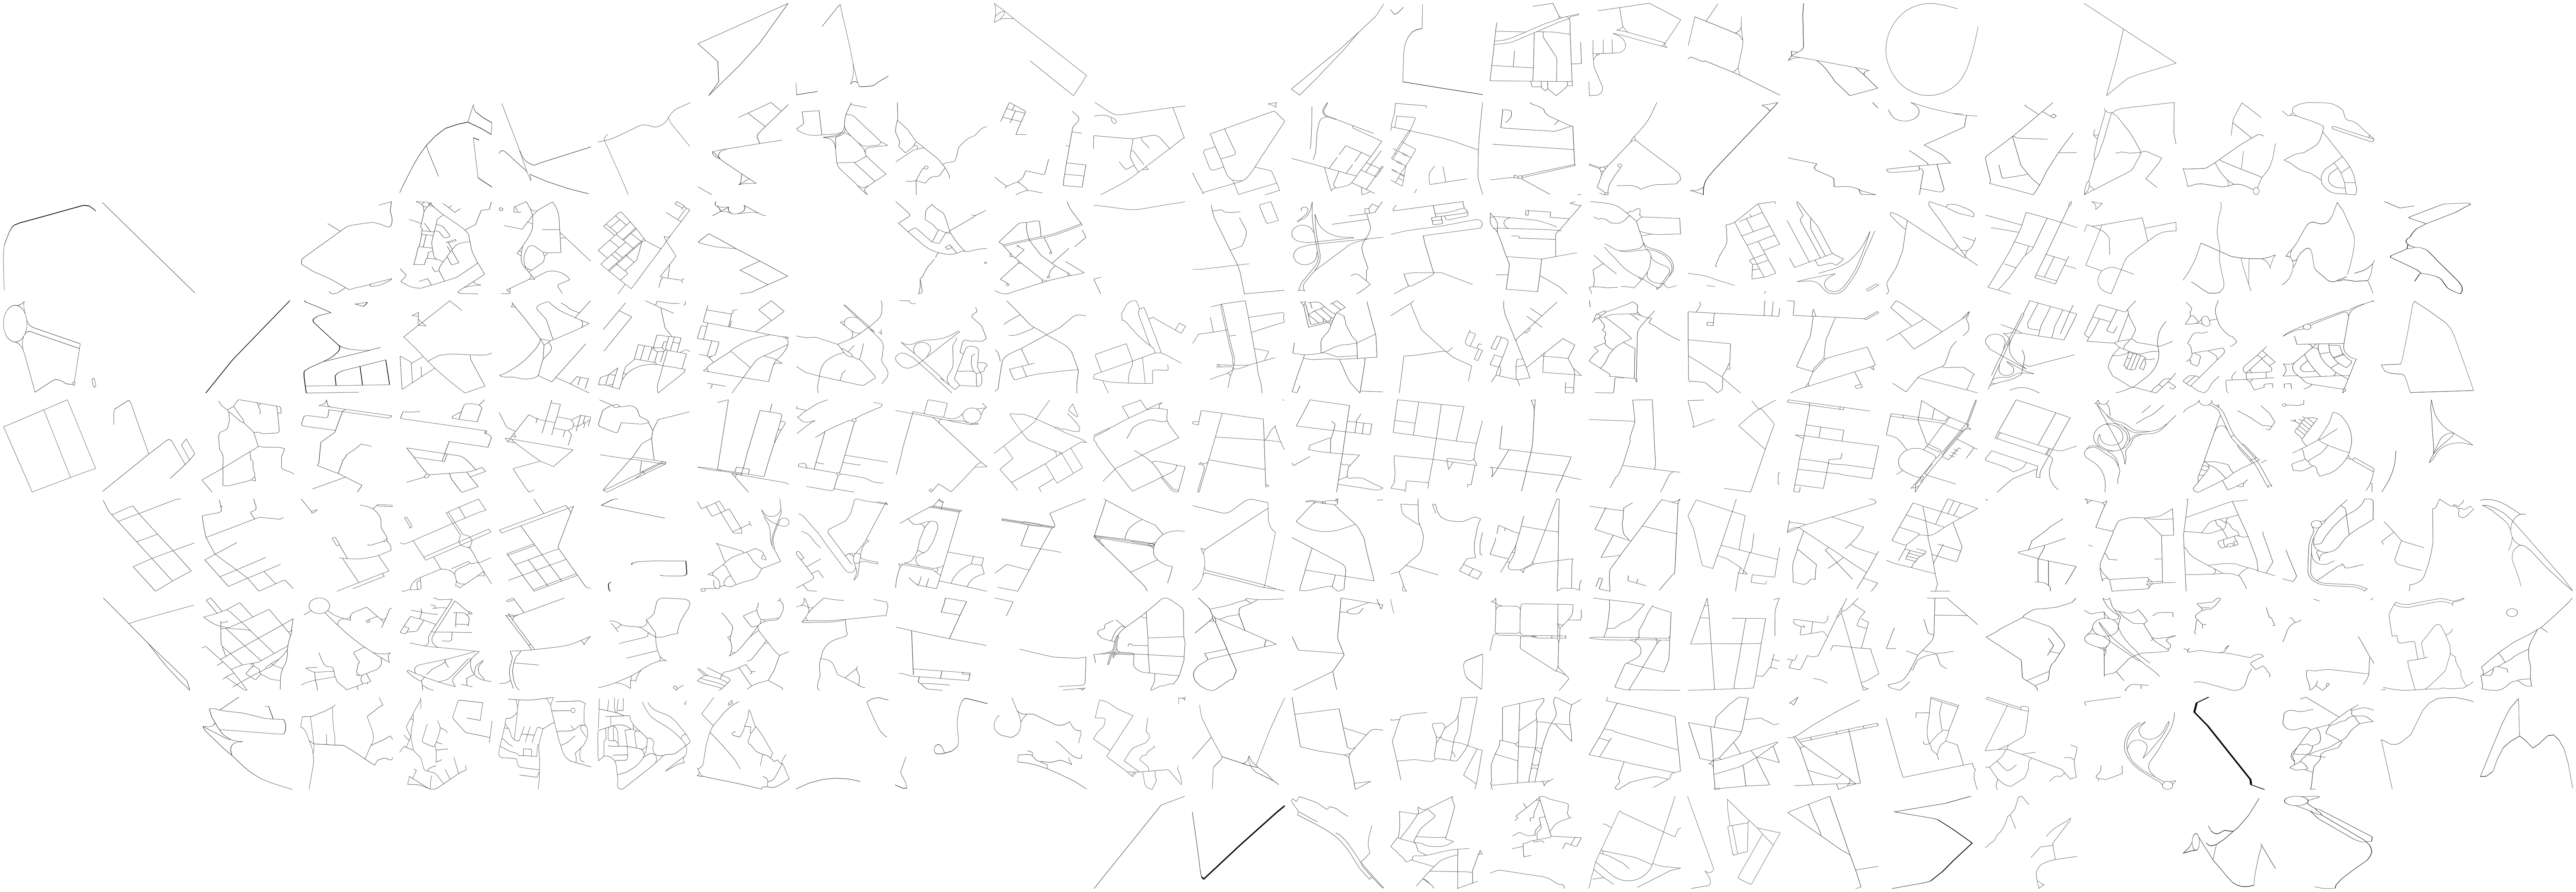

In [ ]:
import os
import json

def reconstruct_map(patch_metadata_path, output_path="data/reconstructed_map.png"):
    # Load patch metadata
    with open(patch_metadata_path, "r") as f:
        patches = json.load(f)

    # --- 1. Find global bounds ---
    minx = min(p["bbox"]["minx"] for p in patches)
    miny = min(p["bbox"]["miny"] for p in patches)
    maxx = max(p["bbox"]["maxx"] for p in patches)
    maxy = max(p["bbox"]["maxy"] for p in patches)

    patch_size_x = patches[0]["bbox"]["maxx"] - patches[0]["bbox"]["minx"]
    patch_size_y = patches[0]["bbox"]["maxy"] - patches[0]["bbox"]["miny"]

    img_w, img_h = Image.open(patches[0]["image_path"]).size

    # --- 2. Compute number of patches ---
    nx = math.ceil((maxx - minx) / patch_size_x)
    ny = math.ceil((maxy - miny) / patch_size_y)

    print(f"Reconstructing map grid {nx} x {ny} patches")

    # --- 3. Create blank canvas ---
    canvas_w = nx * img_w
    canvas_h = ny * img_h
    full_map = Image.new("RGB", (canvas_w, canvas_h), "white")

    # --- 4. Place each patch ---
    for p in patches:
        bbox = p["bbox"]
        img_path = p["image_path"]
        img = Image.open(img_path).convert("RGB")

        # Compute grid position
        i = int((bbox["minx"] - minx) / patch_size_x)
        j = int((bbox["miny"] - miny) / patch_size_y)

        # Convert to pixel position (invert y for top-down layout)
        x_px = i * img_w
        y_px = canvas_h - (j + 1) * img_h

        full_map.paste(img, (x_px, y_px))

    # --- 5. Save reconstructed map ---
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    full_map.save(output_path)
    print(f"✅ Reconstructed map saved to {output_path}")
    return full_map
reconstruct_map("data/patches/patch_metadata.json", "data/full_map.png")

In [22]:
import json
from PIL import Image, ImageDraw
import os

def reconstruct_map(metadata_path, output_path="reconstructed_map.png"):
    with open(metadata_path, "r") as f:
        metadata = json.load(f)

    # Compute global bounds
    minx = min(p["bbox"]["minx"] for p in metadata)
    miny = min(p["bbox"]["miny"] for p in metadata)
    maxx = max(p["bbox"]["maxx"] for p in metadata)
    maxy = max(p["bbox"]["maxy"] for p in metadata)

    # Compute total width and height in geographic units
    width_geo = maxx - minx
    height_geo = maxy - miny

    # Determine scale from patch image size and patch_size (assuming all equal)
    patch_size_geo = metadata[0]["bbox"]["maxx"] - metadata[0]["bbox"]["minx"]
    patch_img = Image.open(metadata[0]["image_path"])
    patch_px = patch_img.width
    scale = patch_px / patch_size_geo  # pixels per geo unit

    # Prepare full canvas
    full_w = int(width_geo * scale)
    full_h = int(height_geo * scale)
    print(f"Canvas size: {full_w} x {full_h}")
    canvas = Image.new("RGB", (full_w, full_h), "white")

    # Paste patches
    for p in metadata:
        img = Image.open(p["image_path"]).convert("RGB")
        bbox = p["bbox"]
        # Compute pixel coordinates relative to global min
        x0 = int((bbox["minx"] - minx) * scale)
        y0 = int((maxy - bbox["maxy"]) * scale)  # invert Y to image coordinates
        canvas.paste(img, (x0, y0))

    # Save result
    canvas.save(output_path)
    print(f"✅ Reconstructed map saved to: {output_path}")

# Example usage
reconstruct_map("mydata/patches/patch_metadata.json")


Canvas size: 3584 x 1279
✅ Reconstructed map saved to: reconstructed_map.png


In [31]:
import pickle
import os

with open('mydata/network_porto/porto_edges_new_simplify.pkl', 'rb') as f:
    edgeinfo = pickle.load(f)
with open('mydata/network_porto/porto_nodes_new.pkl', 'rb') as f:
    nodeinfo = pickle.load(f)

In [32]:
import numpy as np
import glob
files = sorted(glob.glob("mydata/*.npy"))
arrays = [np.load(f, allow_pickle=True) for f in files]
combined_array = np.concatenate(arrays, axis=0)

: 

: 

In [6]:
def compute_global_bbox(data, nodeinfo, edgeinfo):
    """
    Compute the overall bounding box (minx, miny, maxx, maxy)
    across all links in the dataset.
    """
    minx, miny = float("inf"), float("inf")
    maxx, maxy = float("-inf"), float("-inf")

    for l in data:
        links = np.asarray(l[1])
        for link in links:
            info = edgeinfo[link]
            try:
                x_s, y_s = nodeinfo[(info[2])][0], nodeinfo[(info[2])][1]
                x_e, y_e = nodeinfo[(info[3])][0], nodeinfo[(info[3])][1]
            except KeyError:
                print("bad")
                return None, None, None, None

            # Expand the global bounding box
            minx = min(minx, x_s, x_e)
            miny = min(miny, y_s, y_e)
            maxx = max(maxx, x_s, x_e)
            maxy = max(maxy, y_s, y_e)

    return minx, miny, maxx, maxy

In [12]:
minx, miny, maxx, maxy = compute_global_bbox(combined_array, nodeinfo, edgeinfo)
print("Global bounding box:", minx, miny, maxx, maxy)

Global bounding box: -8.6886988 41.1406333 -8.5559061 41.1858412


In [ ]:
x_s, y_s, x_e, y_e = -8.5784108, 41.1445092, -8.5864628, 41.1432353
mid_x = (x_s + x_e) / 2
mid_y = (y_s + y_e) / 2
print(mid_x, mid_y)

-8.5824368 41.14387225


In [ ]:
from shapely.geometry import LineString, box
def find_patches_for_segment(x_s, y_s, x_e, y_e, patches_json):
    """
    Find all patches that intersect the segment defined by start (x_s, y_s) and end (x_e, y_e).
    Ensures unique patches (no duplicates).
    """
    segment = LineString([(x_s, y_s), (x_e, y_e)])
    found_patches = set()

    for patch in patches_json:
        bbox = patch["bbox"]
        patch_box = box(bbox["minx"], bbox["miny"], bbox["maxx"], bbox["maxy"])
        if segment.intersects(patch_box):
            found_patches.add(patch["patch_id"])  # store unique patch IDs

    # return the full patch dicts corresponding to the found IDs
    return [p for p in patches_json if p["patch_id"] in found_patches]

In [ ]:
patches = find_patches_for_segment(x_s, y_s, x_e, y_e, patches_json)
for p in patches:
    print(p["patch_id"], p["bbox"])

NameError: name 'find_patches_for_segment' is not defined

In [14]:
sorted_x = sorted(set([p["bbox"]["minx"] for p in patches_json]))
print(np.diff(sorted_x)[:10])
sorted_y = sorted(set([p["bbox"]["miny"] for p in patches_json]))
print(np.diff(sorted_y)[:10])

[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
[0.01 0.01 0.01 0.01]
